In [ ]:
from google.colab import drive

drive.mount("drive/")

Drive already mounted at drive/; to attempt to forcibly remount, call drive.mount("drive/", force_remount=True).


In [ ]:
import pandas
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

import random
random.seed(1)

In [ ]:
dataset_path = "drive/MyDrive/Copie de IMDB Dataset.csv"
dataset_df = pandas.read_csv(dataset_path)

In [ ]:
dataset_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'\bbr\b', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r"[\"'`]", '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = word_tokenize(text)
    cleaned = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words and token not in string.punctuation
    ]
    return ' '.join(cleaned)

dataset_df['cleaned_reviews'] = dataset_df['review'].apply(clean_text)
print(dataset_df['cleaned_reviews'].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    one reviewer mentioned watching oz episode you...
1    wonderful little production filming technique ...
2    thought wonderful way spend time hot summer we...
3    basically there family little boy jake think t...
4    petter matteis love time money visually stunni...
Name: cleaned_reviews, dtype: object


In [ ]:
dataset_df.head()

,review,sentiment,cleaned_reviews
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [ ]:
le = LabelEncoder()
dataset_df['sentiment_encoded'] = le.fit_transform(dataset_df['sentiment'])

In [ ]:
X = dataset_df['cleaned_reviews']
y = dataset_df['sentiment_encoded']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_val_pad = pad_sequences(X_val_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

In [ ]:
model_lstm = Sequential([
    Input(shape=(100,)),
    Embedding(input_dim=5000, output_dim=128),
    LSTM(128, return_sequences=False),
    Dense(1, activation="sigmoid")
])

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 128)       │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

initial_lr = 1e-4  # 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr, decay_steps=5, decay_rate=0.9)

lr_history = []

class LRLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(K.eval(self.model.optimizer.learning_rate))
        lr_history.append(lr)
        print(f"Epoch {epoch+1}: learning rate = {lr:.6f}")


In [ ]:
optimizer = Adam(learning_rate=lr_schedule)
model_lstm.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

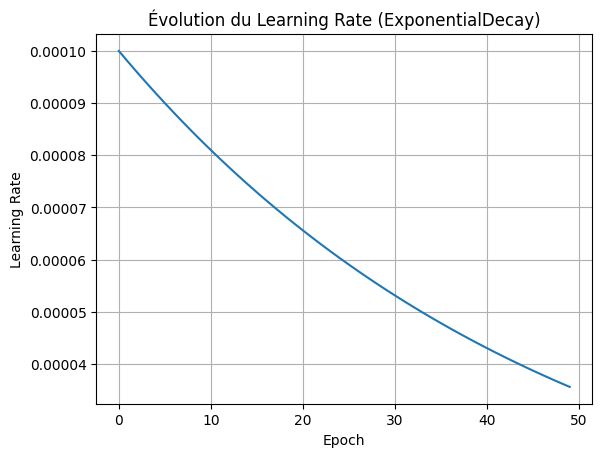

In [ ]:
lrs = [lr_schedule(i).numpy() for i in range(50)]
plt.plot(range(50), lrs)
plt.title("Évolution du Learning Rate (ExponentialDecay)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid()
plt.show()

In [ ]:
model_lstm.fit(X_train_pad, y_train,
               validation_data=(X_val_pad, y_val),
               epochs=1000,
               callbacks=[early_stopping, LRLogger()])

Epoch 1/1000
1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5919 - loss: 0.6919Epoch 1: learning rate = 0.000000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5919 - loss: 0.6919 - val_accuracy: 0.5919 - val_loss: 0.6919
Epoch 2/1000
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5933 - loss: 0.6918Epoch 2: learning rate = 0.000000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.5933 - loss: 0.6918 - val_accuracy: 0.5919 - val_loss: 0.6919
Epoch 3/1000
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5902 - loss: 0.6919Epoch 3: learning rate = 0.000000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.5902 - loss: 0.6919 - val_accuracy: 0.5919 - val_loss: 0.6919
Epoch 4/1000
1092/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5864 - loss: 0.6919Epoch 4: learning rate = 0.000000
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.5864 - loss: 0.6919 - val_accuracy: 0.5919 - val_loss: 0.6919
Epoch 5/1000
1090/1094 ━━━━

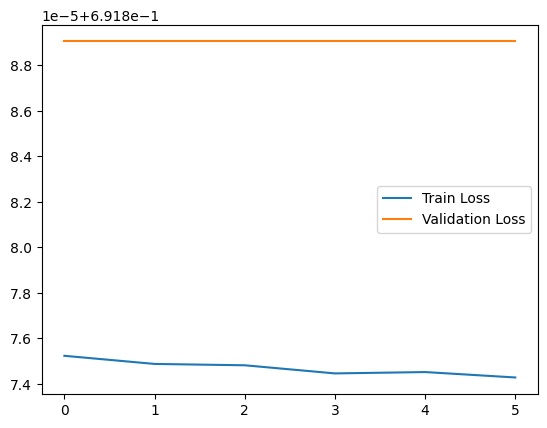

In [ ]:
plt.plot(model_lstm.history.history["loss"])
plt.plot(model_lstm.history.history["val_loss"])
plt.legend(["Train Loss", "Validation Loss"])
plt.show()

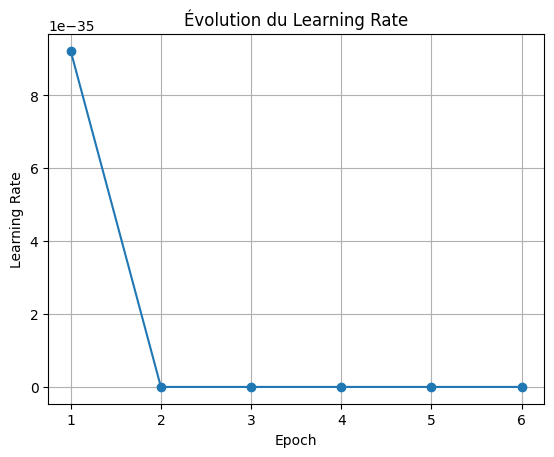

In [ ]:
plt.plot(range(1, len(lr_history)+1), lr_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Évolution du Learning Rate")
plt.grid()
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


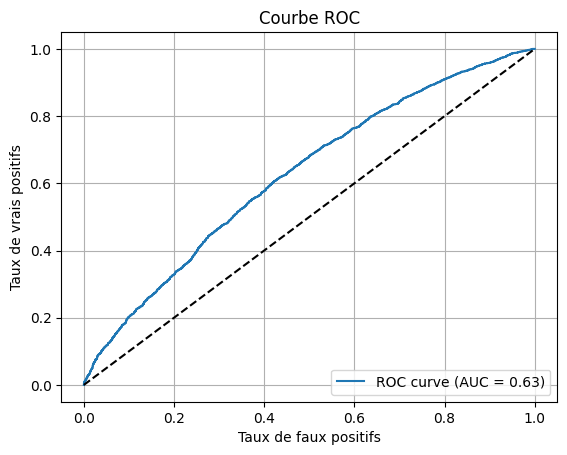

In [ ]:

# Ajout de la courbe ROC et calcul de l’AUC
y_probs = model_lstm.predict(X_val_pad)

fpr, tpr, thresholds = roc_curve(y_val, y_probs)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
# Calcul du seuil optimal

optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Seuil optimal : {optimal_threshold:.4f}")

Seuil optimal : 0.5000


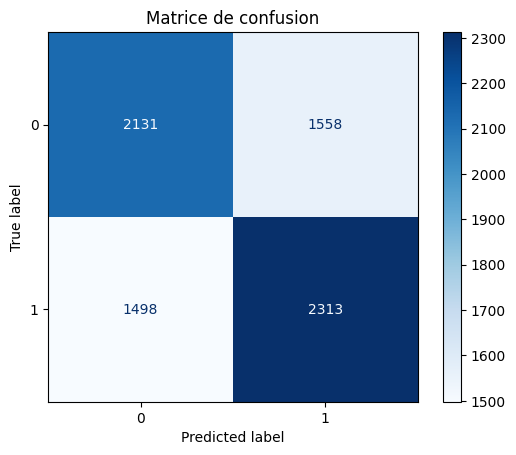

In [ ]:
# Matrice de confusion

y_pred_optimal = (y_probs >= optimal_threshold).astype(int)
cm = confusion_matrix(y_val, y_pred_optimal)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.show()